In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import MyCounter, HUEOrder

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from collections import Counter

def min_max_date(data_):
    dates = sorted(data2.DATE.astype(str).values)
    d0 = dates[0]; d1 = dates[-1]
    d0 = d0[:4] + "/" + d0[4:6] + "/" + d0[6:]
    d1 = d1[:4] + "/" + d1[4:6] + "/" + d1[6:]
    return (d0,d1)

pd.set_option('display.max_columns', None)
#plt.rc('font',family = 'serif')
colors_ = sns.color_palette('viridis', 20)
path = "../data/"

In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
features = ['TAUTH','NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

DB5 = tokamakTK.clean_categorical_data(DB5)

In [5]:
# alpha_R -- 0.6358 --> when considering DB2 for calculation
data1 = DB5[DB5.label.isin([1])].reset_index(drop=True)
# alpha_R -- 2.1246 --> when considering DB2 for calculation
data2 = DB5[DB5.label.isin([0])]
# Removing DB2, because most of these shots have missing info
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

In [6]:
#tokamakTK.get_regression(data1, DB2)[1].summary()

In [7]:
## GROUP 1 -- Decreasing alpha-R the most
print(f"GROUP 1 | size = {len(data1)} | {min_max_date(data1)[0]} | {min_max_date(data1)[-1]}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data1.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data1.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data1['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data1['PHASE'])}")

GROUP 1 | size = 1466 | 1989/06/23 | 2017/10/26
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 11
TYPE-1+5: 7
TYPE-I: 1008
TYPE-II: 98
TYPE-III: 148
TYPE-RF: 5
TYPE-V: 31
UNKNOWN: 158


PHASE
HGELM: 867
HGELMH: 255
HSELM: 322
HSELMH: 22


In [8]:
print(f"GROUP 2 | size = {len(data2)} | {min_max_date(data2)[0]} | {min_max_date(data2)[-1]}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data2.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data2.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data2['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data2['PHASE'])}")

GROUP 2 | size = 3476 | 1989/06/23 | 2017/10/26
Missing Tokamaks: ['ASDEX' 'PBXM' 'PDX']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'COMPASS' 'D3D' 'JET' 'JETILW' 'JFT2M' 'JT60U' 'MAST'
 'NSTX' 'START' 'TCV' 'TDEV' 'TFTR']


ELMTYPE
TYPE-1+2: 21
TYPE-1+5: 13
TYPE-I: 2700
TYPE-II: 188
TYPE-III: 291
TYPE-RF: 25
TYPE-V: 34
UNKNOWN: 204


PHASE
HGELM: 2020
HGELMH: 622
HSELM: 778
HSELMH: 56


In [9]:
tokamak = pd.DataFrame([
    data1["TOK"].value_counts(),
    data2["TOK"].value_counts()
], index=["data1","data2"]).T.fillna(0.0)
tokamak = tokamak.sort_values("data2", ascending=False)

tokamak = (tokamak/len(DB5))*100

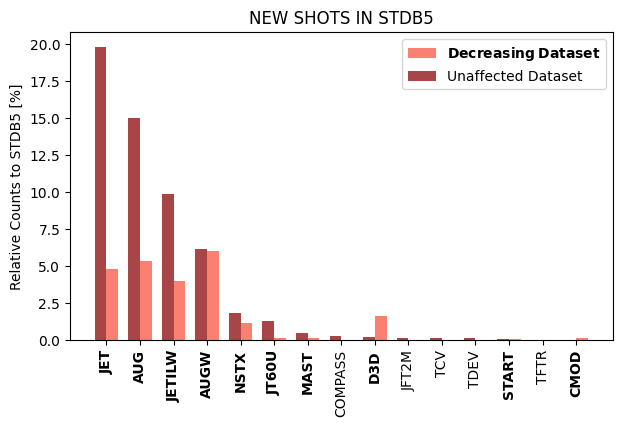

In [13]:
# create a figure with subplots
fig, ax = plt.subplots(figsize=(7, 4))

# define the x and y values for the bars
x = np.arange(len(tokamak.index))
width = 0.35
ax.bar(x + width/2, tokamak['data1'], width, color='salmon', label='$\\bf{Decreasing}\\:\\bf{Dataset}$')
ax.bar(x - width/2, tokamak['data2'], width, color='#A84547', label='Unaffected Dataset')


# set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(tokamak.index, rotation=90)

# Set the font weight of 'AUG' and 'MAST' to bold
for label in plt.gca().xaxis.get_ticklabels():
    if label.get_text() in data1.TOK.unique():
        label.set_fontweight('bold')

# set the y-axis label
ax.set_ylabel('Relative Counts to STDB5 [%]')

# set the plot title and legend
ax.set_title('NEW SHOTS IN STDB5')
ax.legend()

# display the plot
plt.show()